In [796]:
import sys
sys.modules.pop('CLASS_BABY')
sys.modules.pop('CLASS_SAMPLE')


from CLASS_BABY import *
from CLASS_SAMPLE import *

import scipy.stats as ss

#bigger fonts
import matplotlib
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
matplotlib.rcParams.update({'font.size': 20})

In [797]:
T = pd.read_csv('../TOST_data/average_properties.txt',
            sep='\t',index_col=0,na_values=-99,
            dtype={'WEIGHT_GRAMS': float,
                   'GEST_AGE_DAYS':float,
                   'DELTA_SEC_MEASURE':float,
                   'MED_SPO2':float,
                   'MED_PI':float,
                   'MED_PR':float,
                   'MEAN_SPO2':float,
                   'MEAN_PI':float,
                   'MEAN_PR':float,
                   'STD_SPO2':float,
                   'STD_PI':float,
                   'STD_PR':float,
                   'BRADY_SEC_PR':float,
                   'BRADY_RATIO_PR':float,
                   'BRADY_RATIO_PR_m10':float,
                   'BRADY_RATIO_PR_m20':float,
                   'BRADY_RATIO_PR_m30':float,
                   'BRADY_RATIO_PR_m40':float,
                   'BRADY_SEC_SPO2':float,
                   'BRADY_RATIO_SPO2':float,
                   'BRADY_SEC_PR_DYN':float,
                   'BRADY_RATIO_PR_DYN':float})

# Function to count episode of bradycardia (to be added to the class baby)

In [798]:
def get_brady_episodes_durations(t,PR, threshold=100, duration_min=15,time_step=2):
    '''Return a list containing the duration of the episodes of bradycardia. 
    The length of the list is the number of episodes'''
    
    episode_durations = []
    contiguous_time_bin = True
    counter_sec = 0

    for i in range(1,len(t)):
        if PR[i]< threshold and PR[i-1]< threshold and contiguous_time_bin:
            counter_sec = counter_sec + time_step #sec
        else:
            if counter_sec > duration_min:
                episode_durations.append(counter_sec)
            counter_sec = 0

        if t[i-1] == t[i]-time_step:
            contiguous_time_bin = True
        else:
            contiguous_time_bin = False
    return np.array(episode_durations)
        

# Let's count the episode of bradycardia in a perfect sin function

In [799]:
x = np.arange(0,180,2)
y = np.sin(x/10+2)

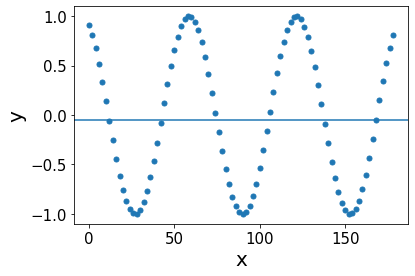

In [800]:
plt.plot(x,y,'.',markersize=10)
plt.axhline(np.mean(y))
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [801]:
get_brady_episodes_durations(t=x,PR=y,duration_min=15,threshold=0.)

array([30, 28, 30])

In [802]:
#let's check instead when the episodes are less than the duration min
# I should obtain an empty list
get_brady_episodes_durations(t=x,PR=y,duration_min=40,threshold=0.)

array([], dtype=float64)

# Testing on a real baby

In [803]:
B = baby('FMC057',verbose=False)

/home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_057/G_FMC057_Day1_Rt wrist.csv
len(dt) before = 1081
len(dt) after = 1081
len(pr) =  1079
len(spo2) =  1079
/home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_057/G_PHN_FMC057_Day5_Rt Foot.csv
len(dt) before = 414
len(dt) after = 414
len(pr) =  414
len(spo2) =  414
/home/giorgio/Desktop/NHS/TOST_data/TOST FMC Data Groomed/G_FMC_PHN_057/G_PHN_FMC057_Day5_Rt wrist.csv
len(dt) before = 599
len(dt) after = 599
len(pr) =  599
len(spo2) =  599


G_PHN_FMC057_Day5_Rt Foot.csv


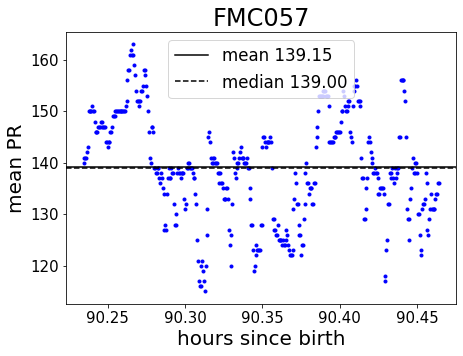

In [804]:
B.plot_baby_measurements(filenumber=1,only_PR=True,with_bad_values=False)

In [730]:
filenumber = 1
time  = np.array(B.measurements_delta_sec_since_birth_list[filenumber])
pulse = np.array(B.measurements[filenumber]['PR'])

sel =  np.where(pulse>10.)

time = time[sel]
pulse = pulse[sel]


#thr = (2./3.)*np.median(pulse)
thr = 110

episodes = get_brady_episodes_durations(t=time,
                                        PR=pulse,
                                        duration_min=15,
                                        threshold=thr)

print('Threshold = ',thr)#,' (2/3 median)')
print('Duration of episodes in seconds = ',episodes)#/60./60.
print('Number of episodes = ',len(episodes))

Threshold =  110
Duration of episodes in seconds =  [24 32 16 16]
Number of episodes =  4


In [512]:
B.measurements_bradycardia_episodes_durations[1]

array([202,  44,  18])

In [513]:
B.measurements_bradycardia_episodes_number[1]

3